In [1]:
"""
@author: Pearl Saldanha
"""

import numpy as np
import matplotlib.pyplot as plt
import nxsdk.api.n2a as nx
from nxsdk.utils.plotutils import plotRaster
import wta1d as wta1d
import os
os.environ["KAPOHOBAY"] = "1"


def create_spikegen(net, indices, spiketimes, numPorts=None):
    """
    creates a spikegenerator from a list of indices with corresponding spiketimes
    :param net: the nx net in which the spikegen is created
    :param indices: the neuron indices that correspond to the spiketimes
    :param spiketimes: times at which the spikegen spikes
    :param numPorts: the numebr of spikegen neurons, if None, it is the max of indices
    :param time_step: time in milliseconds
    :return: spikegenerator (needed to connect to other groups)
    """
    if numPorts is None:
        numPorts = np.max(indices)
        
    print('length of stimulation is', np.max(spiketimes), 'timesteps')
    spikegen = net.createSpikeGenProcess(numPorts=numPorts)
    for sg_neuron in np.unique(np.asarray(indices)):
        spikegen.addSpikes(spikeInputPortNodeIds=sg_neuron,
                           spikeTimes=list(spiketimes[np.where(indices == sg_neuron)]))
    return spikegen

In [2]:
net = nx.NxNet()

training_learning = True # if false then it means you are in the recall phase which means that there is no spikes given to the spikegen resulting in synfire chain not firin

#ports
num_syn = 36
num_recall =  36 

# num_syn2 = 30
# num_recall2 = 30 

spiketimes=[]
spiketimes = np.asarray([5,6,7,8,9,10,11,12]) 
indices =np.asarray([0]*len(spiketimes))

# spiketimes1 = np.asarray([3000, 3001 , 3002, 3003, 3004 , 3005, 3006, 4000, 4001, 4002, 4003, 4004, 4005, 4006])
# indices1 =np.asarray([0]*len(spiketimes))

time_step = 1.00 #GLOBAL time step duration in milliseconds (spiking rate and time constant defined in MILLISECONDS)
simulated_time = 1000 #length of the simulation in milliseconds
sumulated_steps = int(simulated_time/time_step) #number of simulated steps
runtime = sumulated_steps

print("Length of 'indices' = ", len(indices))
print("Length of 'spiketime' = ", len(spiketimes))
print("Print-out of indices array: ", indices)


Length of 'indices' =  8
Length of 'spiketime' =  8
Print-out of indices array:  [0 0 0 0 0 0 0 0]


In [3]:
sf1 = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=20000,
                            functionalState=2,
                            refractoryDelay=2,
                            compartmentVoltageDecay=int(4096/20),
                            compartmentCurrentDecay=int(4096/15),
                            numDendriticAccumulators = 16,   
                            enableSpikeBackprop = 1,
                            enableSpikeBackpropFromSelf = 1,
                            logicalCoreId=0)

synfire1 = net.createCompartmentGroup(size=num_syn, prototype=sf1)

# sf2 = nx.CompartmentPrototype(biasMant=0,
#                             biasExp=0,
#                             vThMant=20000,
#                             functionalState=2,
#                             refractoryDelay=2,
#                             compartmentVoltageDecay=int(4096/20),
#                             compartmentCurrentDecay=int(4096/15),
#                             numDendriticAccumulators = 16,   
#                             logicalCoreId=0)

# synfire2 = net.createCompartmentGroup(size=num_syn2, prototype=sf2)

#connection prototype
conn_proto_exc = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY,
                                        weight=145,
                                        weightExponent=4,
                                        numWeightBits=6,
                                        enableDelay=1,
                                        numDelayBits =4,
                                        delay=14)

#connection mask                                     
conn_mask = np.zeros((num_syn,num_syn))
for i in range(num_syn-1):
    #conn_mask[i,i+1]= 1
    conn_mask[i+1,i] = 1
    
print(conn_mask)
plt.imshow(conn_mask)

#compartment connections
exc_exc = synfire1.connect(synfire1, prototype=conn_proto_exc,connectionMask=conn_mask)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


length of stimulation is 12 timesteps


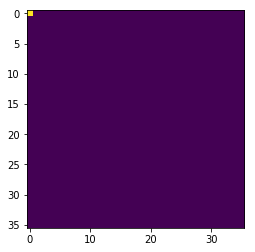

In [4]:
# =======================================================
# Creation of connections from spikeGen to synfire chain
# =======================================================

# Connection mask for the spikeGen
conn_mask_spikegen = np.zeros((num_syn, num_syn))
# conn_mask_spikegen[0,:] = 1  # Connects all spikeGen ports to only the first neuron in the synfire chain
conn_mask_spikegen[0,0] = 1  # Connects only the first port of the spikeGen to the first neuron in the synfire chain

# Draw excitatory connections from the spikeGen (using 'conn_mask_spikegen')
# sg = create_spikegen(net, indices, spiketimes, numPorts=num_src)

# spike_gen.connect(cx_grp,
#                   prototype=conn_proto,
#                   weight=np.ones((num_dst, num_src)) * int(weight_steps),
#                   delay=np.ones((num_dst, num_src)) * int(delay_steps),
#                   connectionMask=conn_mask)

# # Plot connection mask
# if plotConnMatrices or printConnMatrices:
#     print("Connection matrix for spike gen to synfire chain:")
# if plotConnMatrices:
plt.imshow(conn_mask_spikegen)
# if printConnMatrices:
#     print(conn_mask_spikegen)


# spike generator
sg = create_spikegen(net, indices, spiketimes, numPorts=num_syn)
sg.connect(synfire1,
           prototype=conn_proto_exc,
            connectionMask=conn_mask_spikegen)


In [5]:
#Add probes
(u_probes, v_probes, s_probes) = synfire1.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                               nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                               nx.ProbeParameter.SPIKE])

In [6]:
net.run(runtime)
net.disconnect()

INFO:DRV:  Connecting to 127.0.0.1:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.01s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.01s)
INFO:DRV:      Executing... Done (6.04s)
INFO:DRV:      Processing timeSeries... Done (0.63s)
INFO:DRV:  N2Driver: Finished (6.71s)


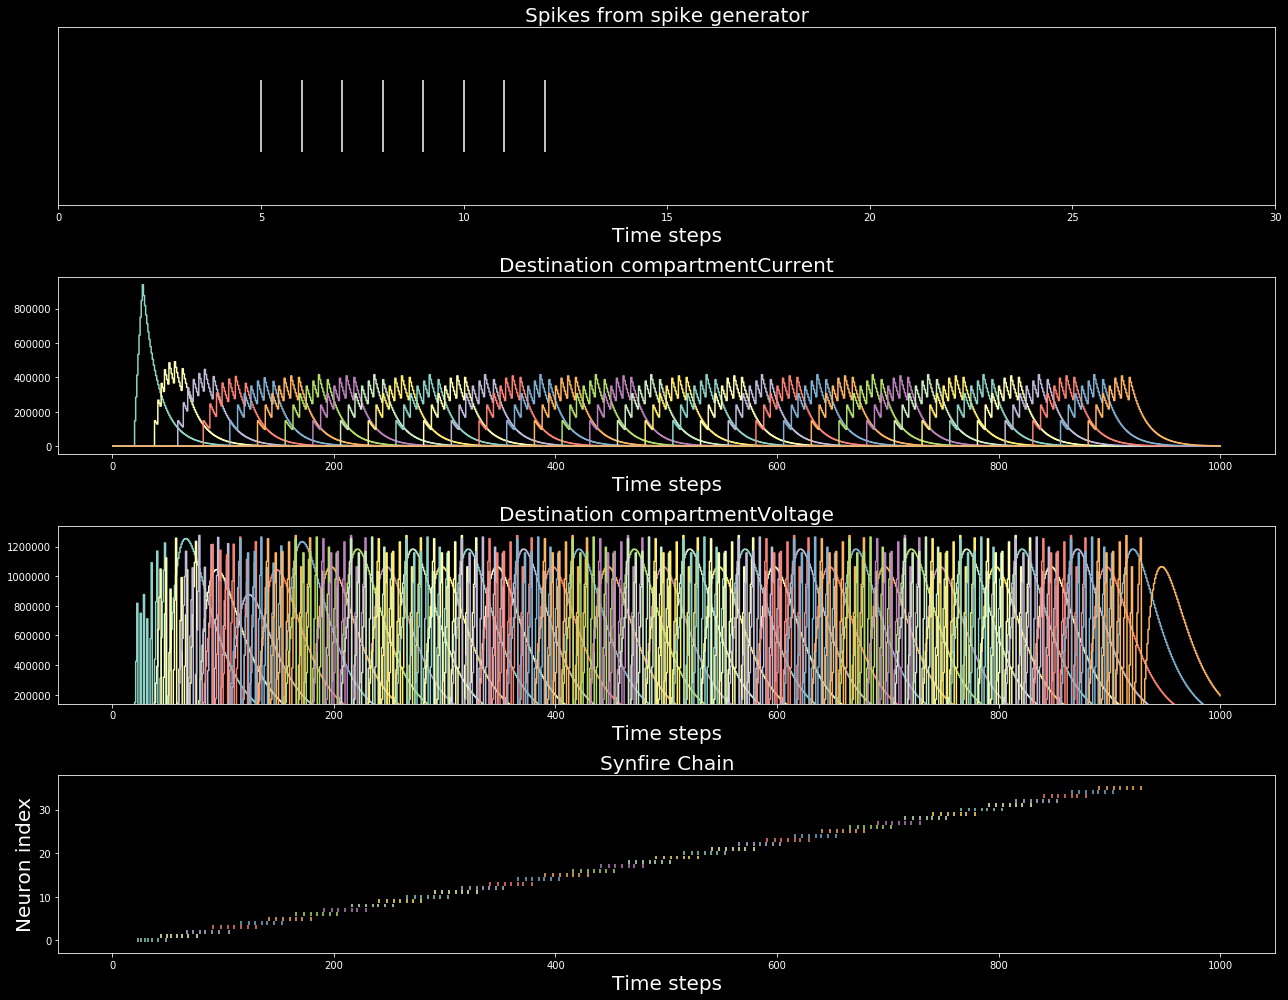

In [10]:
fig = plt.figure(1, figsize=(18,14))
plt.style.use("dark_background") 
# Plot destination compartment current
ax1 = plt.subplot(4,1,2)
uh = u_probes.plot()
plt.xlabel('Time steps',fontsize = 20)
plt.title('Destination compartmentCurrent',fontsize = 20)

ax2 = plt.subplot(4,1,3)
vh = v_probes.plot()
plt.ylim(2200*64)
plt.xlabel('Time steps',fontsize = 20)
plt.title('Destination compartmentVoltage', fontsize = 20)

# Plot destination spikes
ax3 = plt.subplot(4,1,4)
sh = s_probes.plot(colors=[h.get_color() for h in uh])
ax3.set_xlim(ax1.get_xlim())
plt.xlabel('Time steps',fontsize = 20)
plt.ylabel('Neuron index',fontsize = 20)
plt.title('Synfire Chain',fontsize = 20)

# Plot source spikes
ax0 = plt.subplot(4,1,1)
sh = plotRaster([spiketimes])
# ax0.set_xlim(ax1.get_xlim())
plt.xlim(0,30)
plt.yticks([])
plt.xlabel('Time steps',fontsize = 20)
plt.title('Spikes from spike generator',fontsize = 20)

plt.tight_layout()
plt.show()

fig.savefig("Example for synfire chain")